In [3]:
#Imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from forecasting_model import ForecastingModel
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error)

Matplotlib is building the font cache; this may take a moment.


In [60]:
# Create a dataset
seq_len = 46
train_size = 460
data = list(pd.read_csv("bonn_ndvi.csv")["ndvi"])[0:]
x = np.array(data[:train_size])
forecast = np.array(data[train_size:])
X = np.array([x[ii:ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, seq_len, 1))
Y = np.array([x[ii+seq_len] for ii in range(0, x.shape[0]-seq_len)]).reshape((-1, 1))

In [55]:
# Training Loop
device = "mps"
EPOCHS = 40
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
model = ForecastingModel(seq_len, embed_size=64, nhead=16, 
                         dim_feedforward=1024, dropout=0.1, 
                         conv1d_emb=False, conv1d_kernel_size=5, device=device).to(device)
model.train()
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = ExponentialLR(optimizer, gamma=0.9)
dataset = TensorDataset(torch.Tensor(X).to(device), torch.Tensor(Y).to(device))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
for epoch in range(EPOCHS):
    for xx, yy in dataloader:
        optimizer.zero_grad()
        out = model(xx)
        loss = criterion(out, yy)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: Loss={loss}")

Epoch 1/40: Loss=3.055793058592826e-06
Epoch 2/40: Loss=0.002951614558696747
Epoch 3/40: Loss=0.009532409720122814
Epoch 4/40: Loss=0.0001620752300368622
Epoch 5/40: Loss=0.0010423097992315888
Epoch 6/40: Loss=0.026939842849969864
Epoch 7/40: Loss=0.0019842423498630524
Epoch 8/40: Loss=0.015658637508749962
Epoch 9/40: Loss=0.0004187693411950022
Epoch 10/40: Loss=0.0005830706795677543
Epoch 11/40: Loss=0.00010748053318820894
Epoch 12/40: Loss=4.402783088153228e-05
Epoch 13/40: Loss=0.006347211077809334
Epoch 14/40: Loss=0.00022068838006816804
Epoch 15/40: Loss=0.008120473474264145
Epoch 16/40: Loss=0.0009059728472493589
Epoch 17/40: Loss=0.00014867744175717235
Epoch 18/40: Loss=0.0016551788430660963
Epoch 19/40: Loss=0.000221580863581039
Epoch 20/40: Loss=0.0015349506866186857
Epoch 21/40: Loss=0.0014777593314647675
Epoch 22/40: Loss=0.0015727196587249637
Epoch 23/40: Loss=0.006689170841127634
Epoch 24/40: Loss=5.514329473044199e-07
Epoch 25/40: Loss=0.00016249401960521936
Epoch 26/40: 

In [61]:
# Prediction Loop
model.eval()
for ff in range(len(forecast)):
    xx = x[len(x)-seq_len:len(x)]
    yy = model(torch.Tensor(xx).reshape((1, seq_len, 1)).to(device))
    x = np.concatenate((x, yy.detach().cpu().numpy().reshape(1,)))

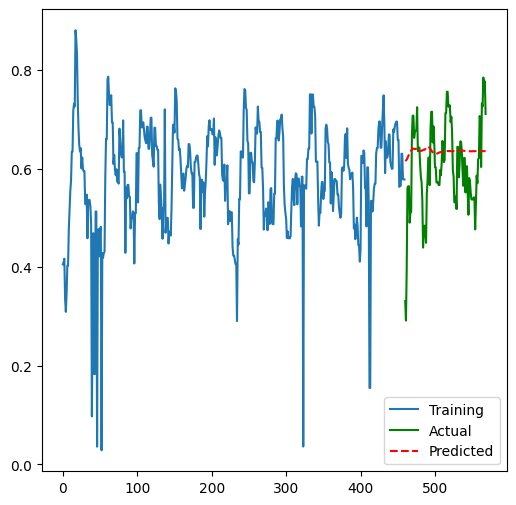

In [62]:
# Plot Predictions
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6))
plt.plot(range(train_size), data[:train_size], label="Training")
plt.plot(range(train_size, len(data)), forecast, 'g-', label="Actual")
plt.plot(range(train_size, len(data)), x[train_size:], 'r--', label="Predicted")
plt.legend()
fig.savefig("./ndvi_example.png")

In [63]:
# Export Metrics
print(f"MSE: {mean_squared_error(x[train_size:], forecast)}")
print(f"MAE: {mean_absolute_error(x[train_size:], forecast)}")

MSE: 0.008441628977938943
MAE: 0.07295774271728797
